# Predicting a Server’s CPU Utilization Rate from Network Indicators

In this project, you will design, explain, and evaluate a **regression model** capable of anticipating a server’s **CPU load** from network indicators, as would be done in a **Security Operations Center (SOC)** to **detect overloads** (e.g., DDoS) and **abnormal behavior**.


## The dataset (network logs)
Each observation corresponds to a **time interval** and contains the variables:

- `tcp_connections`: number of active TCP connections  
- `data_volume_MB`: transmitted volume (MB)  
- `packet_loss_rate`: packet loss rate (%)  
- `ids_alerts`: number of IDS alerts  
- `cpu_load`: CPU load, *target variable to predict*


## Build an Advanced Linear Regression Model by Following These Steps:

1. Understanding the context  
- Understand the lab objective: predict a server’s CPU load from network indicators in a SOC setting.  
- Identify the explanatory variables and the target variable.

2. Data simulation and import  
- Load the simulated dataset (soc_cpu_dataset.csv).  
- Check the structure and first rows with `df.head()`.

3. Exploration and preprocessing  
- General overview: descriptive statistics, data types.  
- Correlations: analyze the relationship between each variable and `cpu_load`.  
- Standardization: scale variables (mean 0, variance 1) to make them comparable.

4. Splitting into sets  
- Perform a Train/Test Split (80% training, 20% testing).  
- Verify the shapes of the resulting datasets.

5. Feature selection  
- Use Sequential Feature Selection (`SequentialFeatureSelector`) with linear regression.  
- Identify the most relevant variables for predicting `cpu_load`.

6. Modeling and evaluation  
- Fit a linear regression model on the selected variables.  
- Evaluate the model using:
  - **R²** (goodness of fit),  
  - **RMSE** (root mean squared error),  
  - a plot of predictions vs. actual values.

7. Model improvement  
- Add interaction or polynomial terms (`PolynomialFeatures`).  
- Retrain the model and compare performance (R², RMSE).  
- Analyze residuals to check model quality.

8. Conclusion and recommendations  
- Identify the variables with the strongest impact on CPU load.


<hr>

Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline


In [2]:
df = pd.read_csv('../Data/cpu_load_data.csv')
df.head()

,tcp_connections,data_volume_MB,packet_loss_rate,ids_alerts,cpu_load
0,1176,8785.993412,0.167662,7,103.489820
1,1509,7433.609316,2.849448,20,124.307937
2,910,7000.455836,3.812293,17,75.312681
3,1344,7054.592431,4.383828,29,111.447631
4,1180,3658.962397,1.710409,17,58.513370


In [3]:
print(f" dimension : {df.shape}")



 dimension : (500, 5)


In [4]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tcp_connections   500 non-null    int64  
 1   data_volume_MB    500 non-null    float64
 2   packet_loss_rate  500 non-null    float64
 3   ids_alerts        500 non-null    int64  
 4   cpu_load          500 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 19.7 KB
None


In [5]:
print(df.describe())

       tcp_connections  data_volume_MB  packet_loss_rate  ids_alerts  \
count       500.000000      500.000000        500.000000  500.000000   
mean       1055.626000     5020.209236          2.526169   24.964000   
std         554.832927     2899.730516          1.474920   14.757041   
min          51.000000      207.292750          0.023160    0.000000   
25%         594.500000     2526.350630          1.167228   12.000000   
50%        1083.000000     5078.990411          2.578816   25.000000   
75%        1534.250000     7550.991890          3.822507   38.000000   
max        1995.000000     9997.204966          4.989671   49.000000   

         cpu_load  
count  500.000000  
mean    74.092776  
std     37.119868  
min      3.925035  
25%     45.454861  
50%     67.256479  
75%    100.025005  
max    179.353562  


In [6]:
print("les valaurs nuls :",df.isnull().sum())

les valaurs nuls : tcp_connections     0
data_volume_MB      0
packet_loss_rate    0
ids_alerts          0
cpu_load            0
dtype: int64


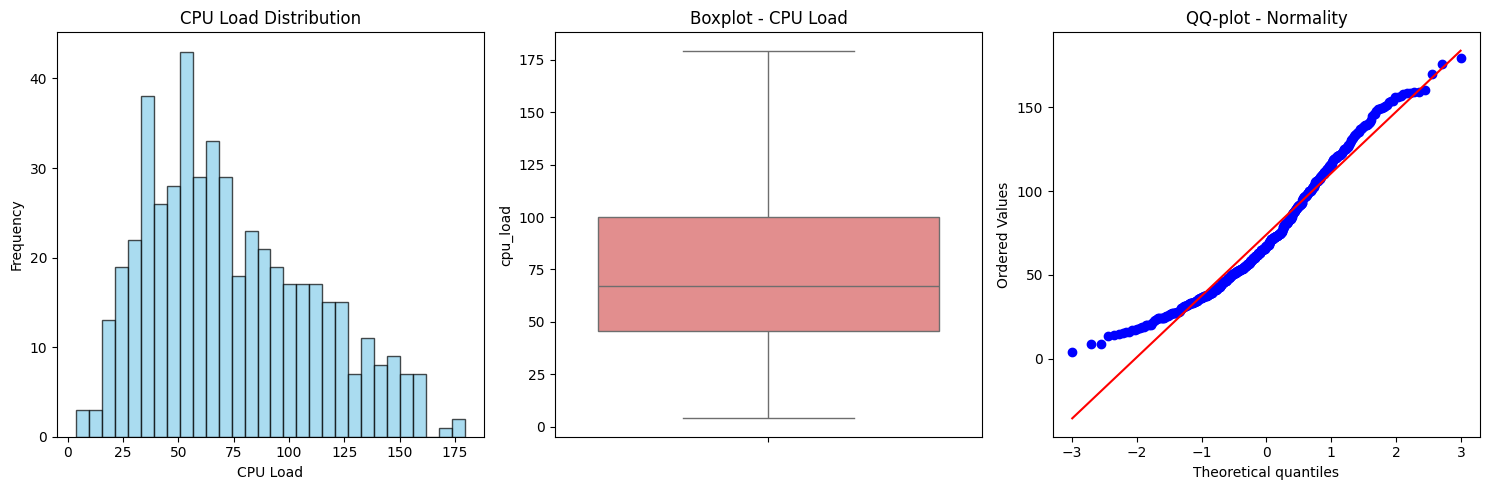

Mean: 74.09
Median: 67.26
Standard deviation: 37.12
Min: 3.93
Max: 179.35


In [7]:
# Analysis of the cpu_load distribution
plt.figure(figsize=(15, 5))

# Histogram
plt.subplot(1, 3, 1)
plt.hist(df['cpu_load'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
plt.title('CPU Load Distribution')
plt.xlabel('CPU Load')
plt.ylabel('Frequency')

# Boxplot
plt.subplot(1, 3, 2)
sns.boxplot(y=df['cpu_load'], color='lightcoral')
plt.title('Boxplot - CPU Load')

# QQ-plot for normality check
plt.subplot(1, 3, 3)
from scipy import stats
stats.probplot(df['cpu_load'], dist="norm", plot=plt)
plt.title('QQ-plot - Normality')

plt.tight_layout()
plt.show()

print(f"Mean: {df['cpu_load'].mean():.2f}")
print(f"Median: {df['cpu_load'].median():.2f}")
print(f"Standard deviation: {df['cpu_load'].std():.2f}")
print(f"Min: {df['cpu_load'].min():.2f}")
print(f"Max: {df['cpu_load'].max():.2f}")


Remarks :

**Histogram: Right-skewed distribution**                
The histogram highlights a strongly right-skewed distribution. Most CPU load values fall between 50 and 100 units, while a long tail extends up to around 180 units, indicating frequent and significant load spikes. This asymmetry suggests the server usually operates under moderate load, but is regularly subjected to high peaks.

**Boxplot: Frequent outliers**                 
The boxplot reveals a large number of outliers above the usual range. The median, close to 70–80, along with the box stretching toward higher values, confirms strong variability in CPU loads.

**QQ-Plot: Non-normality confirmed**                 
The S-shaped pattern of the QQ-plot shows a systematic deviation from normality. The points clearly depart from the theoretical line, indicating that the observed distribution differs significantly from a normal distribution.

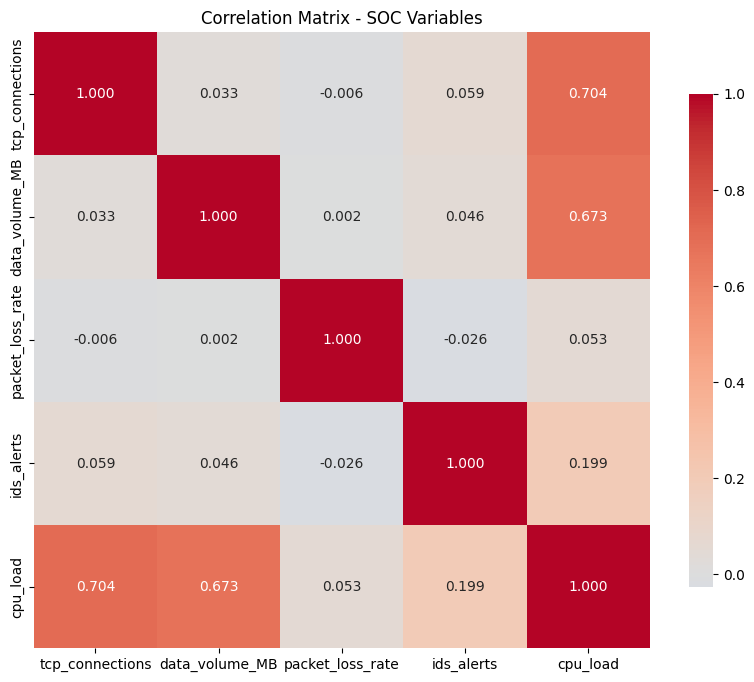

CORRELATIONS WITH CPU_LOAD:
cpu_load             :   1.000
tcp_connections      :   0.704
data_volume_MB       :   0.673
ids_alerts           :   0.199
packet_loss_rate     :   0.053


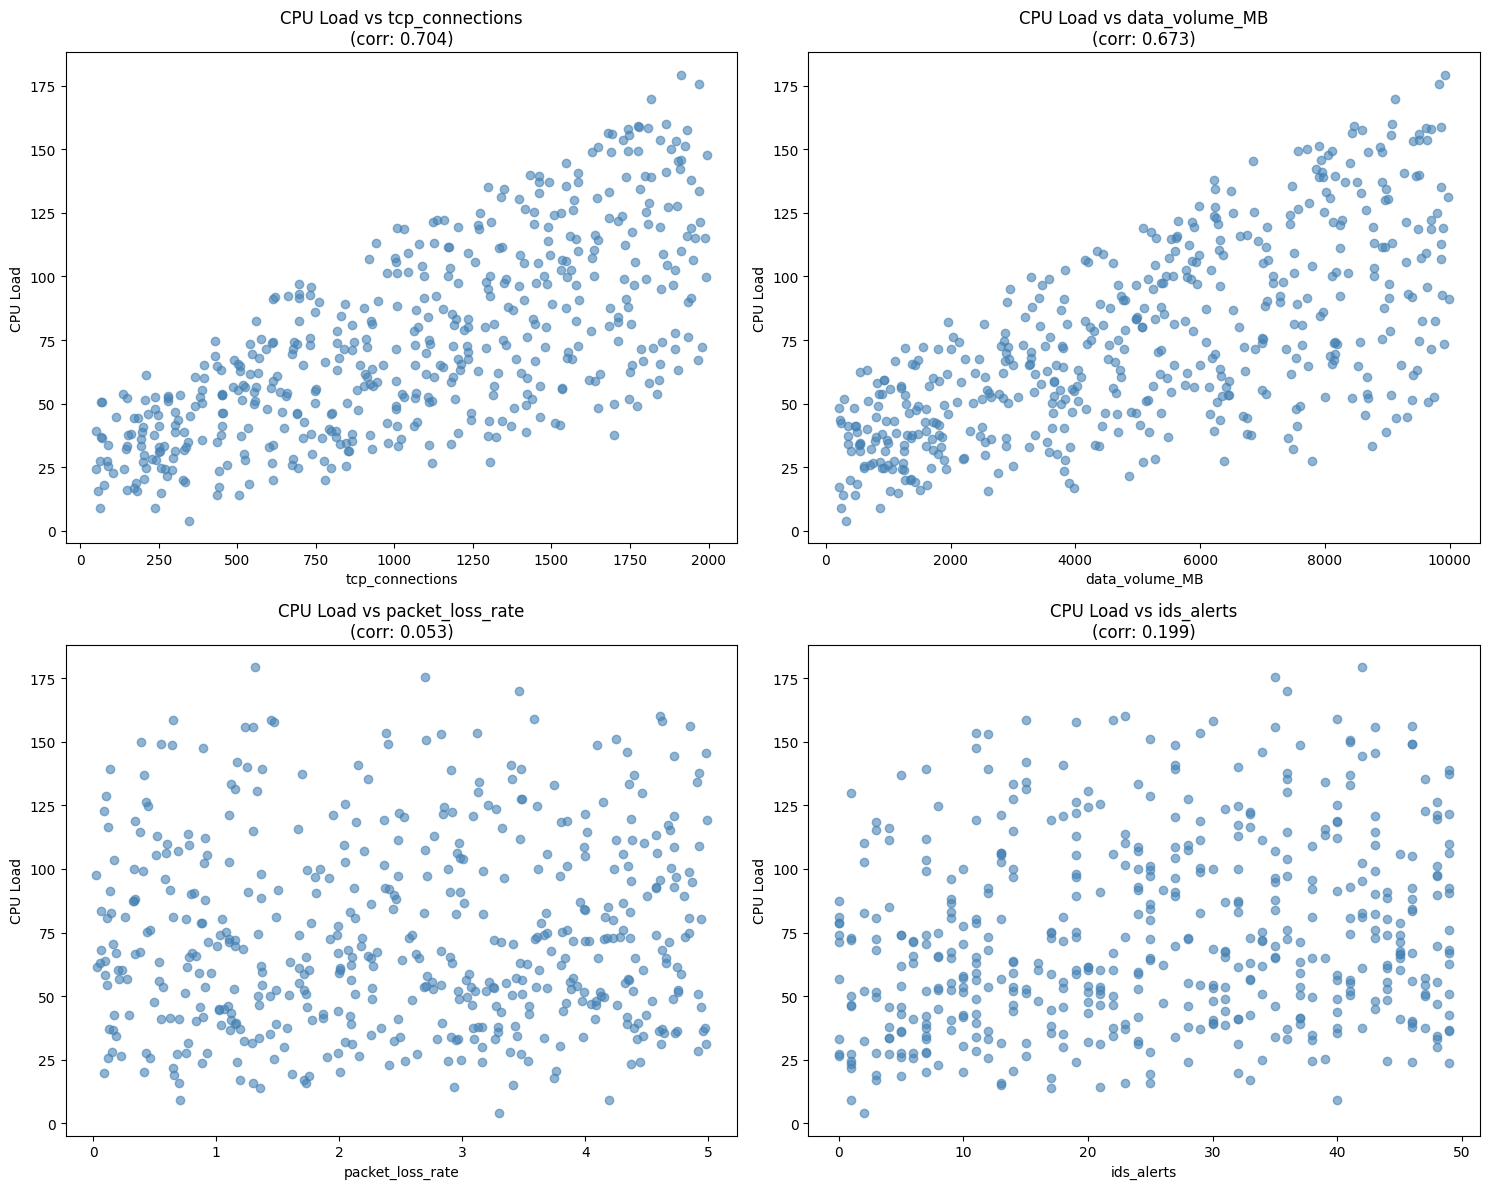

In [8]:
# Correlation matrix
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix - SOC Variables')
plt.show()

# Focus on correlations with CPU
print("CORRELATIONS WITH CPU_LOAD:")
cpu_correlations = correlation_matrix['cpu_load'].sort_values(ascending=False)
for var, corr in cpu_correlations.items():
    print(f"{var:20} : {corr:7.3f}")

# Visualization of individual relationships
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
features = ['tcp_connections', 'data_volume_MB', 'packet_loss_rate', 'ids_alerts']

for i, feature in enumerate(features):
    row, col = i // 2, i % 2
    axes[row, col].scatter(df[feature], df['cpu_load'], alpha=0.6, color='steelblue')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('CPU Load')
    axes[row, col].set_title(
        f'CPU Load vs {feature}\n(corr: {correlation_matrix.loc[feature, "cpu_load"]:.3f})'
    )

plt.tight_layout()
plt.show()


The correlation matrix shows which variables are most strongly related to CPU load. Based on the visualizations, we can see that the variables most highly correlated with the target variable are **tcp_connections** and **data_volume_MB**.

In [9]:
# Split features/target
X = df.drop('cpu_load', axis=1)
y = df['cpu_load']

print("explanatory variables:")
print(X.columns.tolist())


explanatory variables:
['tcp_connections', 'data_volume_MB', 'packet_loss_rate', 'ids_alerts']


In [10]:
# Feature standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("\n STANDARDIZATION:")
for col in X_scaled.columns:
    print(f"{col:20} : mean={X_scaled[col].mean():7.3f}, std={X_scaled[col].std():7.3f}")



 STANDARDIZATION:
tcp_connections      : mean=  0.000, std=  1.001
data_volume_MB       : mean=  0.000, std=  1.001
packet_loss_rate     : mean= -0.000, std=  1.001
ids_alerts           : mean=  0.000, std=  1.001


In [11]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

print(f"\n TRAIN/TEST SPLIT:")
print(f"Train: {X_train.shape[0]} samples")
print(f"Test : {X_test.shape[0]} samples")
print(f"Ratio: {X_test.shape[0] / (X_train.shape[0] + X_test.shape[0]) * 100:.1f}%")



 TRAIN/TEST SPLIT:
Train: 400 samples
Test : 100 samples
Ratio: 20.0%


Variable selection avoids overfitting and improves interpretability.

In [12]:
# Model initialization
lr_model = LinearRegression()

# Forward sequential feature selection
print(" STARTING FEATURE SELECTION ")
sfs = SequentialFeatureSelector(
    estimator=lr_model,
    n_features_to_select='auto',
    direction='forward',
    scoring='r2',
    cv=5,
    n_jobs=-1
)

sfs.fit(X_train, y_train)

# Selected features
selected_features = X_train.columns[sfs.get_support()].tolist()
print(f"\n SELECTED FEATURES ({len(selected_features)}):")
for feature in selected_features:
    print(f"  • {feature}")

# Subsets with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"\n SHAPES AFTER SELECTION:")
print(f"Train: {X_train_selected.shape}")
print(f"Test : {X_test_selected.shape}")


 STARTING FEATURE SELECTION 

 SELECTED FEATURES (2):
  • tcp_connections
  • data_volume_MB

 SHAPES AFTER SELECTION:
Train: (400, 2)
Test : (100, 2)


In [13]:
# Model training
from sklearn.metrics import mean_absolute_error

lr_simple = LinearRegression()
lr_simple.fit(X_train_selected, y_train)

# Predictions
y_pred_simple = lr_simple.predict(X_test_selected)

# Evaluation
r2_simple = r2_score(y_test, y_pred_simple)
rmse_simple = np.sqrt(mean_squared_error(y_test, y_pred_simple))
mae_simple = mean_absolute_error(y_test, y_pred_simple)

print(" SIMPLE MODEL PERFORMANCE:")
print(f"R²    : {r2_simple:.4f}")
print(f"RMSE  : {rmse_simple:.4f}")
print(f"MAE   : {mae_simple:.4f}")

# Model coefficients
coefficients = pd.DataFrame({
    'Variable': selected_features,
    'Coefficient': lr_simple.coef_,
    'Absolute_Impact': np.abs(lr_simple.coef_)
}).sort_values('Absolute_Impact', ascending=False)

print("\n MODEL COEFFICIENTS:")
print(coefficients.to_string(index=False))

print(f"\n \n INTERCEPT: {lr_simple.intercept_:.2f}")


 SIMPLE MODEL PERFORMANCE:
R²    : 0.9056
RMSE  : 11.2471
MAE   : 8.9051

 MODEL COEFFICIENTS:
       Variable  Coefficient  Absolute_Impact
tcp_connections    25.789686        25.789686
 data_volume_MB    24.744557        24.744557

 
 INTERCEPT: 74.06


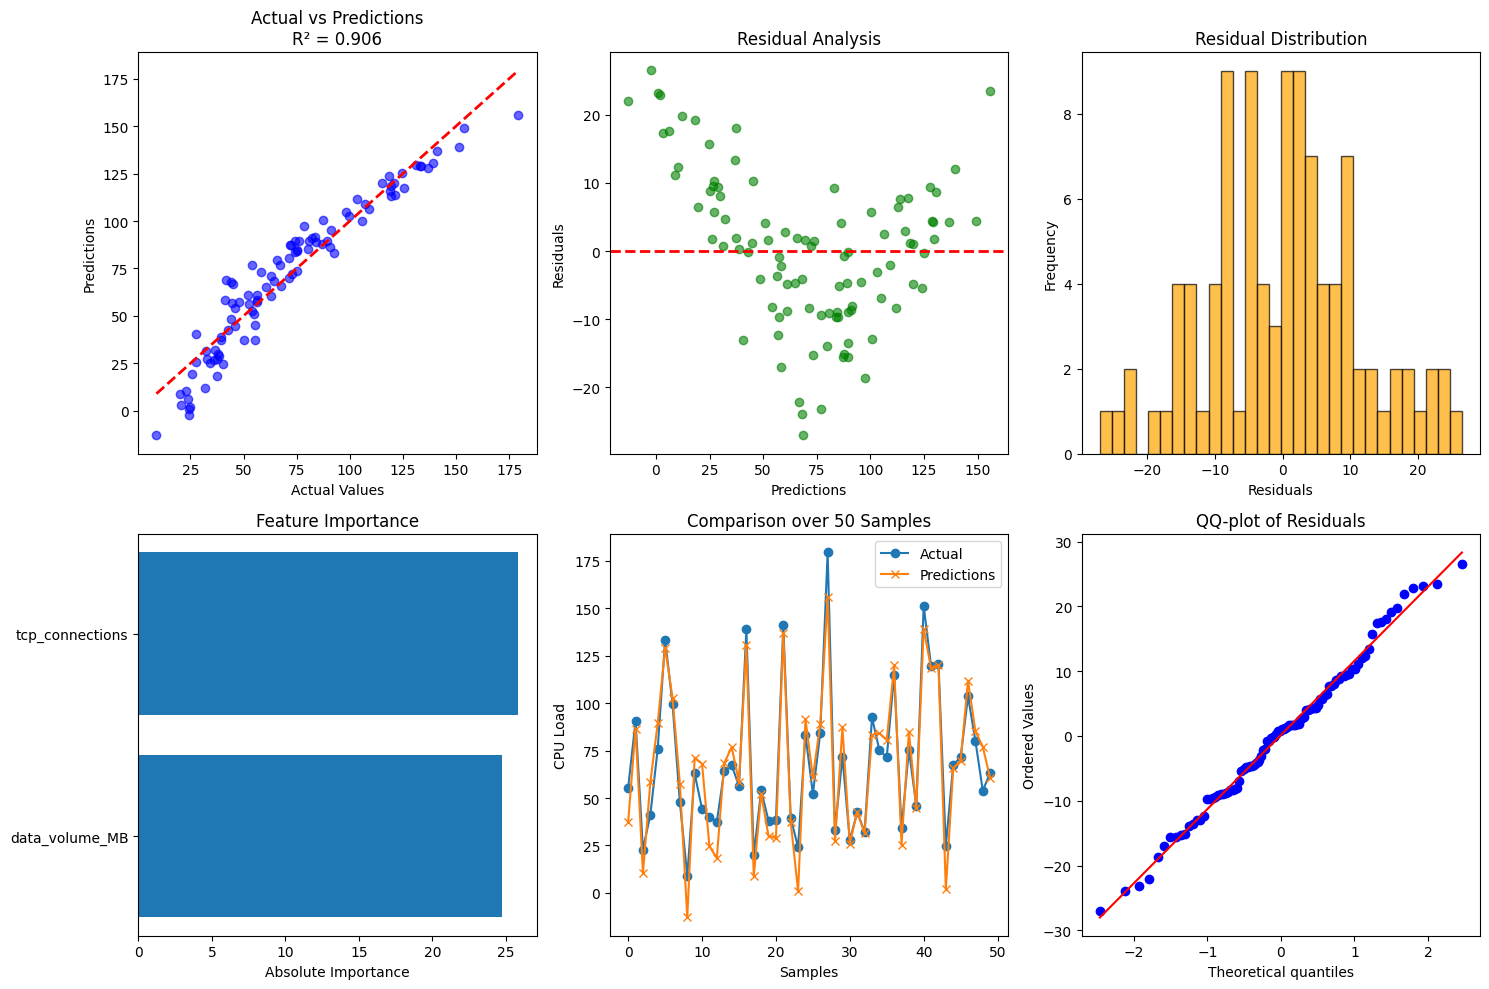

RESIDUAL ANALYSIS:
Mean of residuals: 0.1576
Std. deviation of residuals: 11.3026
Residuals in [-27.03, 26.48]

 NORMALITY TEST (Shapiro-Wilk):
p-value = 0.7278
Residuals follow a normal distribution


In [14]:
# Full visualization
plt.figure(figsize=(15, 10))

# Plot 1: Predicted vs Actual
plt.subplot(2, 3, 1)
plt.scatter(y_test, y_pred_simple, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title(f'Actual vs Predictions\nR² = {r2_simple:.3f}')

# Plot 2: Residuals
residuals_simple = y_test - y_pred_simple
plt.subplot(2, 3, 2)
plt.scatter(y_pred_simple, residuals_simple, alpha=0.6, color='green')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residual Analysis')

# Plot 3: Residuals distribution
plt.subplot(2, 3, 3)
plt.hist(residuals_simple, bins=30, edgecolor='black', alpha=0.7, color='orange')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')

# Plot 4: Feature importance
plt.subplot(2, 3, 4)
feature_importance = coefficients.sort_values('Absolute_Impact', ascending=True)
plt.barh(feature_importance['Variable'], feature_importance['Absolute_Impact'])
plt.xlabel('Absolute Importance')
plt.title('Feature Importance')

# Plot 5: Actual vs predicted values (temporal view)
plt.subplot(2, 3, 5)
plt.plot(y_test.values[:50], label='Actual', marker='o')
plt.plot(y_pred_simple[:50], label='Predictions', marker='x')
plt.xlabel('Samples')
plt.ylabel('CPU Load')
plt.legend()
plt.title('Comparison over 50 Samples')

# Plot 6: QQ-plot of residuals
plt.subplot(2, 3, 6)
stats.probplot(residuals_simple, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')

plt.tight_layout()
plt.show()

# Statistical analysis of residuals
print("RESIDUAL ANALYSIS:")
print(f"Mean of residuals: {residuals_simple.mean():.4f}")
print(f"Std. deviation of residuals: {residuals_simple.std():.4f}")
print(f"Residuals in [{residuals_simple.min():.2f}, {residuals_simple.max():.2f}]")

# Normality test
from scipy.stats import shapiro
stat, p_value = shapiro(residuals_simple)
print(f"\n NORMALITY TEST (Shapiro-Wilk):")
print(f"p-value = {p_value:.4f}")
if p_value > 0.05:
    print("Residuals follow a normal distribution")
else:
    print("Residuals do not follow a normal distribution")


**Excellent Residual Analysis**:                                 
The near-zero mean (0.16) and high p-value (0.73) confirm well-centered and normally distributed residuals, validating the regression assumptions. Only the standard deviation of 11.30, indicating moderate error variability, could be improved for optimal predictive accuracy.

In [15]:
# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_selected)
X_test_poly = poly.transform(X_test_selected)

print(" POLYNOMIAL FEATURES:")
print(f"Before: {X_train_selected.shape[1]} variables")
print(f"After : {X_train_poly.shape[1]} variables")

# Train the polynomial model
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)

# Predictions
y_pred_poly = lr_poly.predict(X_test_poly)

# Evaluation
r2_poly = r2_score(y_test, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
mae_poly = mean_absolute_error(y_test, y_pred_poly)

print("\n POLYNOMIAL MODEL PERFORMANCE:")
print(f"R²    : {r2_poly:.4f}")
print(f"RMSE  : {rmse_poly:.4f}")
print(f"MAE   : {mae_poly:.4f}")

# Model comparison
comparison = pd.DataFrame({
    'Model': ['Simple', 'Polynomial'],
    'R²': [r2_simple, r2_poly],
    'RMSE': [rmse_simple, rmse_poly],
    'MAE': [mae_simple, mae_poly],
    'R² Improvement': ['-', f"+{(r2_poly - r2_simple)*100:.2f}%"]
})

print("\n MODEL COMPARISON:")
print(comparison.to_string(index=False))


 POLYNOMIAL FEATURES:
Before: 2 variables
After : 5 variables

 POLYNOMIAL MODEL PERFORMANCE:
R²    : 0.9719
RMSE  : 6.1418
MAE   : 4.8660

 MODEL COMPARISON:
     Model       R²      RMSE      MAE R² Improvement
    Simple 0.905645 11.247053 8.905113              -
Polynomial 0.971863  6.141794 4.866047         +6.62%


Text(0.5, 1.0, 'Residual Distribution - Polynomial Model')

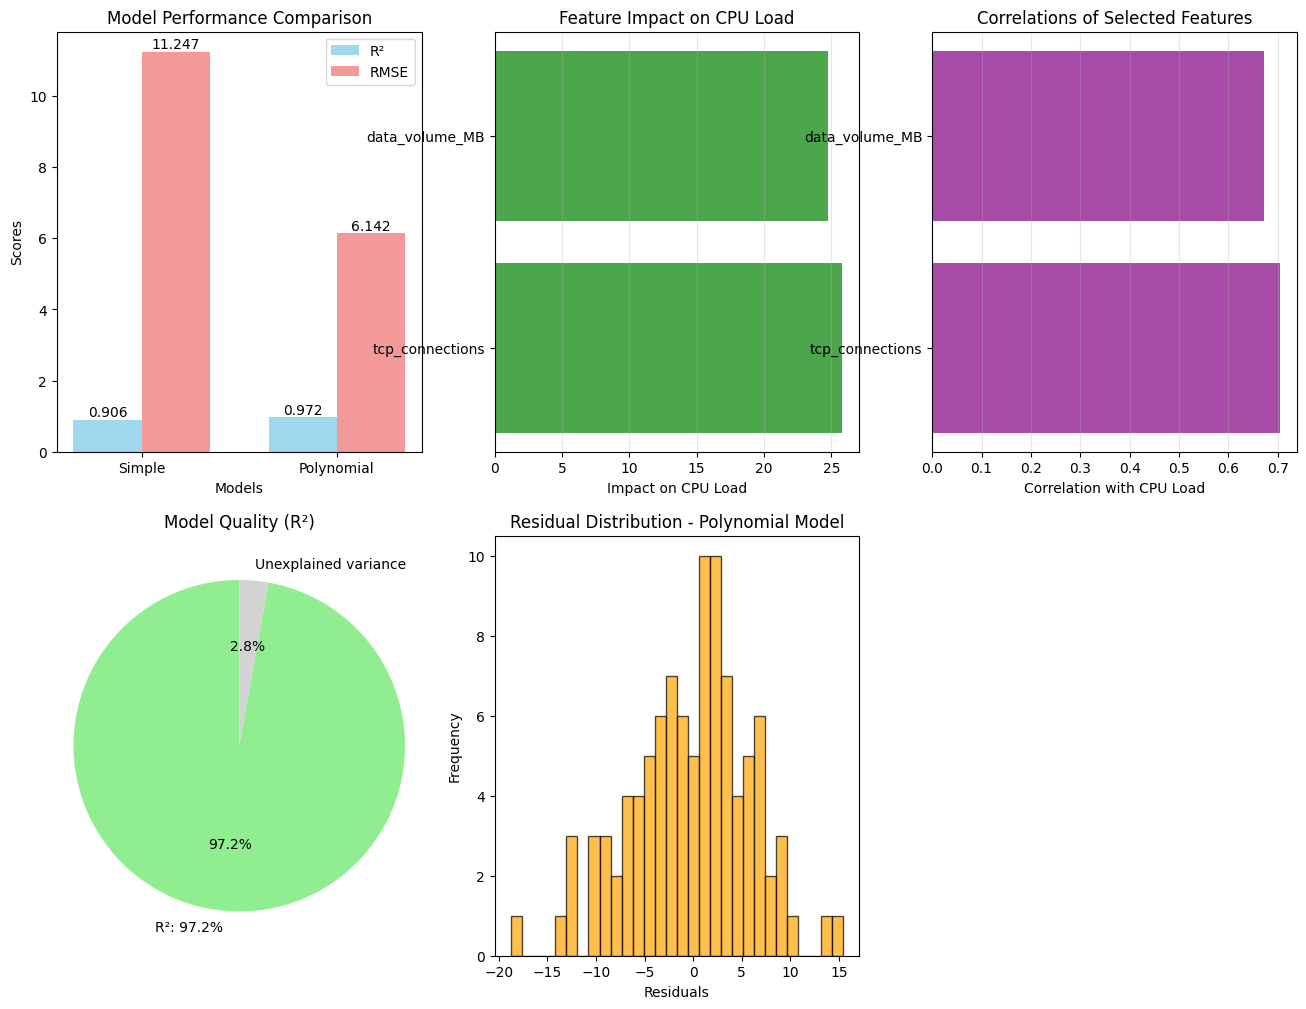

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(16, 12))

# 1. Model performance comparison
plt.subplot(2, 3, 1)
models = ['Simple', 'Polynomial']
r2_scores = [r2_simple, r2_poly]
rmse_scores = [rmse_simple, rmse_poly]

x = np.arange(len(models))
width = 0.35

bars1 = plt.bar(x - width/2, r2_scores, width, label='R²', color='skyblue', alpha=0.8)
bars2 = plt.bar(x + width/2, rmse_scores, width, label='RMSE', color='lightcoral', alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(x, models)
plt.legend()

# Add values on top of the bars
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom')
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom')

# 2. Feature importance (coefficients)
plt.subplot(2, 3, 2)
variables = coefficients['Variable']
impact = coefficients['Coefficient']
colors = ['green' if x > 0 else 'red' for x in impact]

plt.barh(variables, impact, color=colors, alpha=0.7)
plt.xlabel('Impact on CPU Load')
plt.title('Feature Impact on CPU Load')
plt.grid(axis='x', alpha=0.3)

# 3. Correlations with the target variable
plt.subplot(2, 3, 3)
corr_features = selected_features
corr_values = [correlation_matrix.loc[feature, 'cpu_load'] for feature in corr_features]

plt.barh(corr_features, corr_values, color='purple', alpha=0.7)
plt.xlabel('Correlation with CPU Load')
plt.title('Correlations of Selected Features')
plt.grid(axis='x', alpha=0.3)

# 4. Model evaluation (R² gauge)
plt.subplot(2, 3, 4)
r2_value = r2_poly
plt.pie([r2_value, 1 - r2_value],
        labels=[f'R²: {r2_value:.1%}', 'Unexplained variance'],
        colors=['lightgreen', 'lightgray'],
        autopct='%1.1f%%', startangle=90)
plt.title('Model Quality (R²)')
plt.axis('equal')
# 5. Residuals distribution
plt.subplot(2, 3, 5)
residuals_poly = y_test - y_pred_poly
plt.hist(residuals_poly, bins=30, edgecolor='black', alpha=0.7, color='orange')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution - Polynomial Model')   

**The R² of the polynomial model is higher than that of the simple linear model, indicating that it offers better performance and is better able to capture the complex relationships between variables.**